# Intro to simple text classification in keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Default title text
!cp -av /content/drive/MyDrive/London/term_02/coding_3/week_02 /content/

In [ ]:
%cd week_02

/content/week_02


In [2]:
# Do our imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential #base keras model
from tensorflow.keras.layers import Dense, Activation #dense = fully connected layer
from tensorflow.keras.optimizers import SGD

In [3]:
?tf

In [ ]:
#if any of these give you problems, make sure you've installed all libraries used (pandas, sklearn, and matplot lib)
# using conda install or pip install
# see the moodle page "Instructions for setting up and using Python and Jupyter" for more info on how to do this
import pandas as pd
from sklearn.feature_extraction import _stop_words
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import config

physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading a dataset

We're going to use a small set of 1000 movie reviews from IMDB. [The original dataset can be found here.](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download) 

Here's how to load in the dataset into the notebook:

In [ ]:
# This assumes the IMDBsubset.csv file lives in a directory called "data" which lives in the same directory as this notebook.
# ***if you want to edit this notebook to use a different dataset, edit this to specify a different file:
df = pd.read_csv("data/CNN_Articels_clean.csv")

Now we've got the data read in! We've used a special data type called a "data frame", using the Pandas library, to store this data. Pandas makes working with data pretty convenient.

Printing df will show you the data in a table-like format (specifically, it'll show you the first and last few rows of the table).

**Note that a sentiment of "1" means "positive" and "0" means "negative"**

In [ ]:
df

This is great, but if we want to read the full reviews (handy for later) then we can change our display options:

In [ ]:
pd.set_option('display.max_colwidth', None) #show me everything in the column, even if it's long!
df['Category'].unique() #Show me the first and last few examples

array(['news', 'business', 'health', 'entertainment', 'sport', 'politics'],
      dtype=object)

Let's do something super simple to transform this into a dataset that we can send to a neural network. 

Similarly to the sentiment classification we discussed in lecture last week, we're going to represent each example (review) as a vector of word counts.

The CountVectorizer object from sklearn allows us to make these word count vectors pretty easily. Once we do the counts, we'll store these in a new dataframe.


The following code transforms a review dataframe to a word count dataframe called wordcounts.

In [ ]:
# Transform a dataframe containing a column named "review" 
# such that each row becomes represented by a set of word counts, corresponding to the number of each term in the review

#These next two lines perform word counting:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
#stop_words='english' removes very common english words that are unlikely to be useful (e.g. "and", "the")
#min_df=0.1 removes very rare words that are likely to be typos, uninformative, etc.
# You can type ?CountVectorizer in its own cell to read its documentation
#***Note that "df['review']" is used below because "review" is the name of the column containing our text in the dataframe
#If you apply this to your own data, you may probably need to change this column name!
matrix = vectorizer.fit_transform(df['Article text'])
    
#This line converts matrix into another dataframe, with column names corresponding to the word being counted
data = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
?CountVectorizer

Take a look at the data:

In [ ]:
data.shape#prints data to screen

(4076, 5142)

In [ ]:
data

In [ ]:
#or the word hate:
pd.get_dummies(df['Category'])

,business,entertainment,health,news,politics,sport
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
4071,0,0,0,0,0,1
4072,0,0,0,0,0,1
4073,0,0,0,0,0,1
4074,0,0,0,1,0,0


## Let's do some machine learning!

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
#First, let's split our dataset into training and test sets
# Remember: X is for input, y is for output
# The first argument of train_test_split is your training data (here, lives in "data" object you created using word counts)
# The second argument of train_test_split is your labels/targets for the training data. This lives in the "sentiment" column of the original dataframe df we loaded from the file.
# (***If you are using a different dataset, you'll need to change the name of this column to whatever it is in your dataset)
# The test_size argument specifies % of data going into test set: here, 20% of the data goes into test set and 80% goes into training set
X_train, X_test, y_train, y_test = train_test_split(data, pd.get_dummies(df['Category']), test_size=0.2, random_state=0)

In [ ]:
#If you ever want to learn more about a function, you can always use ? 
?train_test_split

In [ ]:
# We can examine it a bit using np.shape:
print(np.shape(X_train)) #What does our training data look like? It's 800 rows, with 1674 dimensions of input (features)
print(np.shape(y_train))

(3260, 5142)
(3260, 6)


In [ ]:
#Now let's make a simple neural network with 1 hidden layer containing 10 neurons
num_neurons = 50 # neurons in each layer
model = Sequential()

#Make the first (hidden) layer, which will have num_neurons neurons. Each neuron will get inputs from all columns of the dataframe, except sentiment
#model.add(Dense(num_neurons, input_dim=len(data.columns)-1))
model.add(Dense(num_neurons, input_dim=np.shape(X_train)[1], activation='relu'))
model.add(Dense(num_neurons, activation='relu'))
model.add(Dense(num_neurons, activation='relu'))
#Now let's add another layer for the output: A single sigmoid neuron.
model.add(Dense(6, activation='softmax'))

In [1]:
?model.summary()

Object `model.summary` not found.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                257150    
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                                 
Total params: 262,556
Trainable params: 262,556
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Use compile() to set up our training

# For loss, we'll use binary cross-entropy loss, 
# which is appropriate for a binary classification problem (0/1 for negative/positive)
# ***If you edit this notebook to apply it to a multi-class classification problem, you'll need 
#    to change the loss to something like categorical_crossentropy, and you'll also need to change the
#    encoding of the class to a one hot representation (see https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)
opt = SGD(lr=0.01, momentum=0.9)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#Train it!
# Plus store history of training in a variable called "history"
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
102/102 [==============================] - 5s 25ms/step - loss: 0.8259 - accuracy: 0.8233 - val_loss: 0.3971 - val_accuracy: 0.8934
Epoch 2/10
102/102 [==============================] - 0s 5ms/step - loss: 0.3692 - accuracy: 0.9184 - val_loss: 0.3252 - val_accuracy: 0.9142
Epoch 3/10
102/102 [==============================] - 1s 10ms/step - loss: 0.2645 - accuracy: 0.9282 - val_loss: 0.2653 - val_accuracy: 0.9154
Epoch 4/10
102/102 [==============================] - 1s 11ms/step - loss: 0.1121 - accuracy: 0.9623 - val_loss: 0.2057 - val_accuracy: 0.9412
Epoch 5/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0578 - accuracy: 0.9776 - val_loss: 0.2840 - val_accuracy: 0.9400
Epoch 6/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0411 - accuracy: 0.9868 - val_loss: 0.3286 - val_accuracy: 0.9363
Epoch 7/10
102/102 [==============================] - 0s 4ms/step - loss: 0.0288 - accuracy: 0.9936 - val_loss: 0.1997 - val_accuracy: 0.9412
Epo

Let's take a look at how training set and test set accuracy change with each epoch:

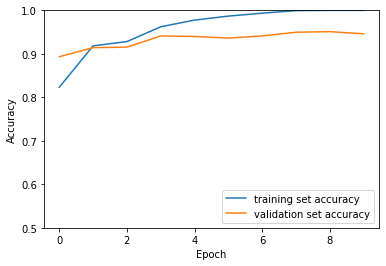

In [ ]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Examining model behaviour

First, let's explore how we can apply the trained model to a specific example in our test data (or training data), to examine what it's done.

We'll use the following code techniques:
* We can apply the trained model to any example using the `.predict()` function
* We can get the nth row from any dataframe using the `.iloc[[n]]` function

In [ ]:
#For instance, let's make z the first test example:
z = X_test.iloc[[0]]

#and let's output the prediction for this example:
model.predict(z)

array([[6.2035216e-14, 6.4361501e-07, 1.8976465e-12, 3.0481562e-09,
        2.6000882e-14, 9.9999940e-01]], dtype=float32)

Note that this prediction will be somewhere between 0 and 1. This can be interpreted loosely as confidence: closer to 1 is more confident it is positive sentiment, closer to 0 is more confident it is negative sentiment.

Let's compare this to the actual sentiment of the review, as stored in y_test:

In [ ]:
y_test.iloc[[0]]

,business,entertainment,health,news,politics,sport
3805,0,0,0,0,0,1


To make sense of this, we probably also want to look at the actual text review, which doesn't live in X_test but does live in the original dataframe we loaded from the CSV file, i.e. `df`. Since our `train_test_split` function has randomised the order of the data before splitting into training and testing sets, we need to get the id (row number) for `df` corresponding to this first test example.

In [ ]:
test_ids = list(X_test.index) #gets the original indices in the df dataframe
#test_ids[n] now refers to the id number of the nth test example
originalReview = df.iloc[[test_ids[0]]].review
originalReview

Try this with a few more examples and see what you find. If you're comfortable with python, can you think of a way to identify misclassified test examples and just print out those? Or, even better, find test examples that are confidently classified correctly, or test examples that are "confidently" misclassified, and examine those?

For more fun, how about testing this classifier on our own new, fake "reviews"? Here's code to create an example of your own and apply the classifier to it. We'll have to first convert a string of text to a vector of word counts and put it in a dataframe, so here's a function for that:

In [ ]:
# Turns a text string into a dataframe example (***Note you'll need to change this from 'review' for your own dataset)
def createExample(myText):

    newExample = np.array([[myText]])
    tdf = pd.DataFrame(newExample, columns=["review"])
    matrix = vectorizer.transform(tdf['review'])
    newDf = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return newDf 

In [ ]:
#Here's a text about zombies
myText = "Meta says it doesn't allow calls for assassinating heads of state - CNN"
t = createExample(myText) #When we print the dataframe, you see zombies' word count is 3:

In [ ]:
#apply the model to classify your new text:
model.predict(t)

array([[0.04048111, 0.43628532, 0.04163552, 0.23183896, 0.02496725,
        0.22479178]], dtype=float32)

Now try writing some "great" and "terrible" reviews and see what happens to the classification outputs:

In [ ]:
model.predict(createExample("This movie is the worst it's terrible horrible"))

array([[0.10694183]], dtype=float32)

In [ ]:
model.predict(createExample("best I have appreciated cheers"))

array([[0.69853514]], dtype=float32)

## Explore on your own

Change the code above to explore:
* Does changing the number of neurons in the hidden layer change the results? What happens to accuracy when you use 1 neuron? 100 neurons? 
* Try editing the neural network so that you have 2 hidden layers of 10 neurons each. What happens to accuracy? 

Investigating the model
* Can you examine the model's performance on the test data to discover anything about what mistakes this model makes? Or anything about what types of reviews are easy to classify accurately?
* Can you come up with your own, new examples of positive or negative reviews that illustrate the mistakes the model makes?